# 2019 中国生理信号挑战赛

有挑战性的单导心电片段 QRS 定位和心率估计

官方比赛地址：[The China Physiological Signal Challenge 2019](http://www.icbeb.org/Challenge.html)

## 目录

- [数据](#数据)
- [评估准则](#评估准则)
- [模型设计](#模型设计)
- [训练](#训练)
- [测试结果](#测试结果)
- [结果提交](#结果提交)

## 数据

- 训练数据：[Train Data](http://www.icbeb.org/file/Training%20data.rar)
- 测试数据：[Test Data]()


1. **数据读取：**

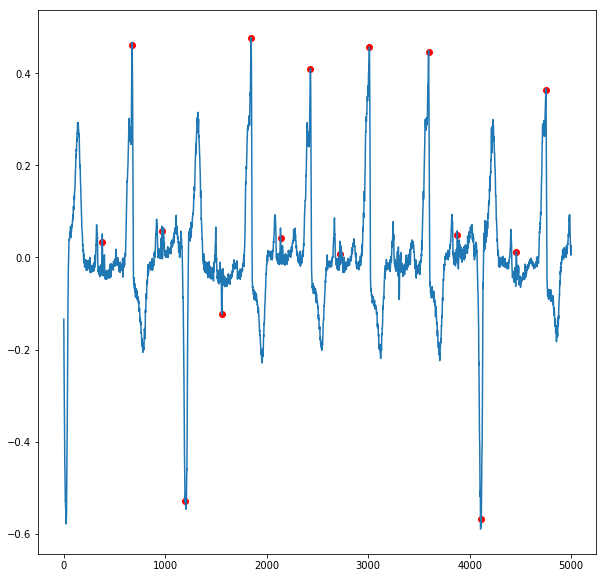

In [84]:
%matplotlib inline

import os.path
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt


def read_train_sample(root, idx, is_display=False):
    sample_data_path = os.path.join(train_data_root, "data", "data_{:05d}.mat".format(idx))
    sample_ref_path = os.path.join(train_data_root, "ref", "R_{:05d}.mat".format(idx))

    sample_data = sio.loadmat(sample_data_path)["ecg"]
    sample_ref = sio.loadmat(sample_ref_path)["R_peak"]

    if is_display is True:
        fig = plt.figure(figsize=[10, 10])
        ax = fig.add_subplot(111)
        ax.plot(sample_data)
        ax.scatter(sample_ref, sample_data[sample_ref.flatten()], c="red")
        fig.show()

    return {"data": sample_data, "ref":sample_ref}



train_data_root="/home/alvin/opt/git/CPSC/data/train/"

idx = 1

sample = read_train_sample(train_data_root, idx, is_display=True)

2. 实现`DataSet`类继承`torch.utils.data.Dataset`

1.0000000000000002
0.027471215105574022


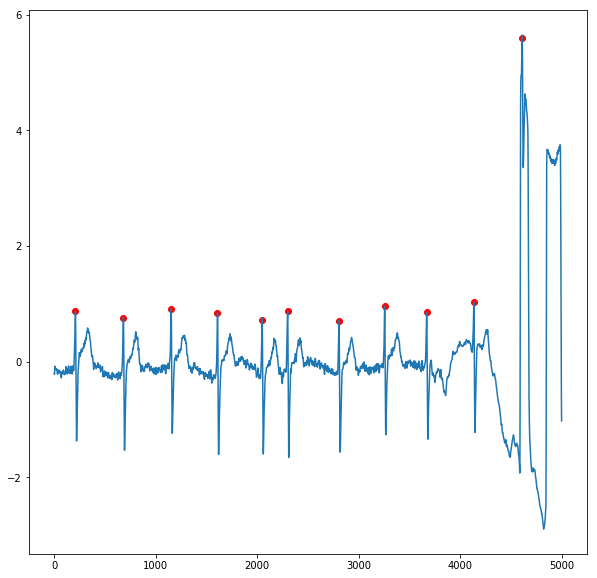

In [136]:
%matplotlib inline

import os.path
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt

from torch.utils.data import Dataset

class TrainData(dict):
    def display(self, figsize=[10, 10]):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.plot(self["data"])
        ax.scatter(self["label"], self["data"][self["label"].flatten()], c="red")
        fig.show()
        
    def normalize(self):
#         self["data"] = self["data"]/(self["data"].max() - self["data"].min())
        self["data"] = (self["data"] - self["data"].mean())/self["data"].std()
        return self
        

class DataSet(Dataset):
    def __init__(self, samples, transform=None):
        super(DataSet, self).__init__()
        self.samples = samples
        self.transform = transform
        
        
    def __getitem__(self, idx):
        sample = TrainData(data=sio.loadmat(self.samples[idx]["data_path"])["ecg"],
                          label=sio.loadmat(self.samples[idx]["ref_path"])["R_peak"])
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample
    
    def __len__(self):
        return len(self.samples)
    
    

def get_all_train_samples(root, N=2000):
    samples = [{
        "data_path":os.path.join(train_data_root, "data", "data_{:05d}.mat".format(idx)),
        "ref_path":os.path.join(train_data_root, "ref", "R_{:05d}.mat".format(idx)),
    } for idx in range(1,N+1)]
    
    return samples
    

train_data_root="/home/alvin/opt/git/CPSC/data/train/"

train_samples = get_all_train_samples(train_data_root)

dataset = DataSet(train_samples)

sample = dataset[100]
sample.normalize().display()
print(sample["data"].var())


sample = dataset[101]
print(sample["data"].var())